In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the words
words = open('names.txt', 'r').read().splitlines()
words[:8]  

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

def build_dataset(words, block_size=3):
    X, Y = [], []
    for word in words:
        # print(word)
        context = [0] * block_size # padded context of 0 tokens ('...' → e)
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '→', ch)
            context = context[1:] + [ix] # move context window by 1 – crop and append

    X = torch.tensor(X) # default for Tensor is float32 and for LongTensor is int64, tensor adjusts
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

In [5]:
# split the dataset 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
block_size = 3 # context length

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [53]:
g = torch.Generator().manual_seed(2147483647)

hidden_layer_size = 200
embedding_dim = 10

# lookup table C
C = torch.randn([27, embedding_dim], generator=g)

# hidden layer
W1 = torch.randn((block_size * embedding_dim, hidden_layer_size), generator=g) * (5/3) / ((block_size * embedding_dim)**0.5)
b1 = torch.randn(hidden_layer_size, generator=g) * 0.01

# output layer
W2 = torch.randn((hidden_layer_size, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [38]:
-torch.tensor(1/27.0).log() # we're expecting initial loss ~ 3.3

tensor(3.2958)

For random initialization on the 0th iteration we have very high loss (27.88), so the initialization is bad. We'd like to have an uniform distribution of logits (equal value).

To achieve this we can set b2 to 0 and scale down W2 to have less extreme values. Why not 0?

Also for h after this initialisation we have a lot of 1 and -1, because of the tanh. That's because hpreact is to far from 0. We can scale down W1 to have less extreme values.

tensor(-0.0032) tensor(1.0030)
tensor(-0.0009) tensor(1.0105)


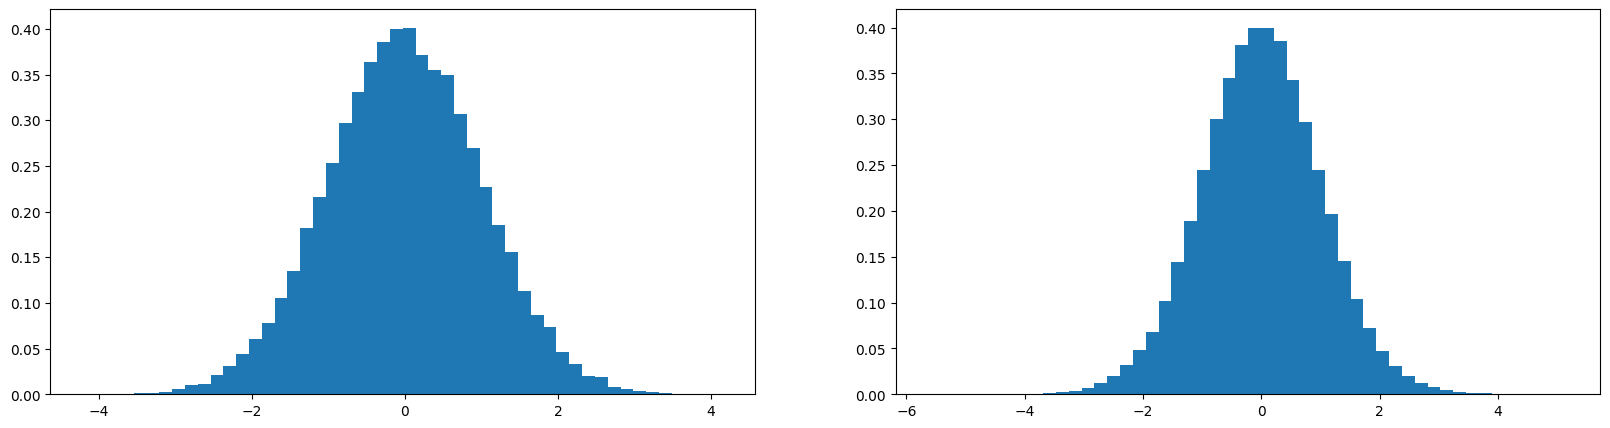

In [52]:
# How to find out how much should we scale the random weights?

x = torch.randn(1000, 30)
w = torch.randn(30, 200) / 30**0.5 # to keep output gaussian with std=1
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) #gaussian, but with more std – more extreme values
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), 50, density=True);

# it's called kaiming normal initialization

Now it's not so importnt to have a perfect initialisation beause of: residual connecion, normalization layers and more complex optimizer (eg. Adam).

In [39]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construction
    ix = torch.randint(0 , Xtr.shape[0], (batch_size, ),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057
2.30228328704834


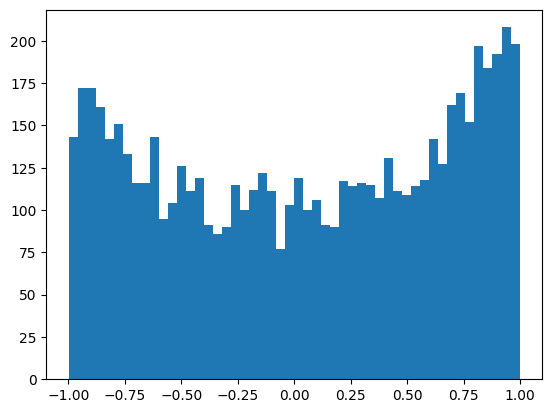

In [41]:
plt.hist(h.view(-1).tolist(), 50);

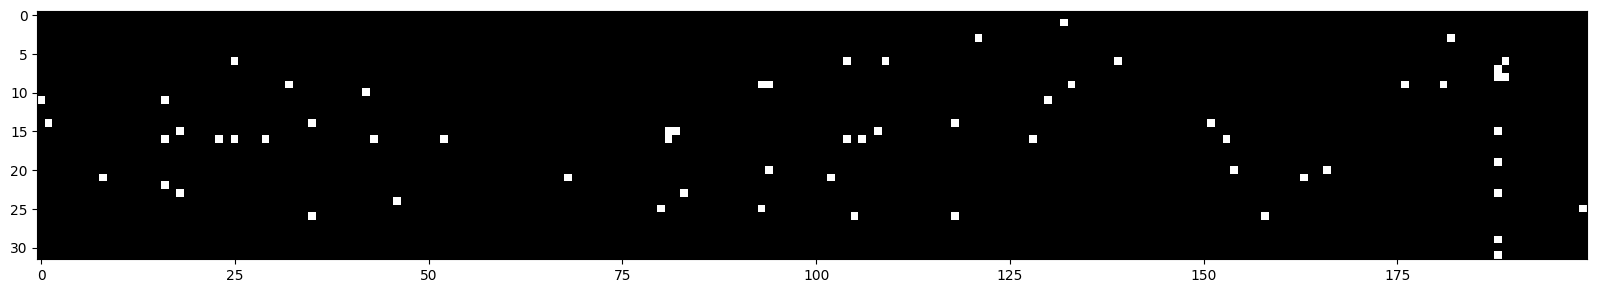

In [43]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation="nearest");

For randomly initialized first layer we have a lot of extreme values. When we backprop of tanh we take (1 - t**2) * out.grad, so we'll have 0, what is stopping the gradient flow – VANISHING GRADIENT.

The white dots are where backward gradient is destroyed. If any column were white, we'd have a dead neuron. However we have some of examples that activies each neuron, so we're learning something.

This is true for tanh, sigmoid (squishing functions), relu, elu (we have negative numbers coming in). Leaky reLU doesn't suffer so much.

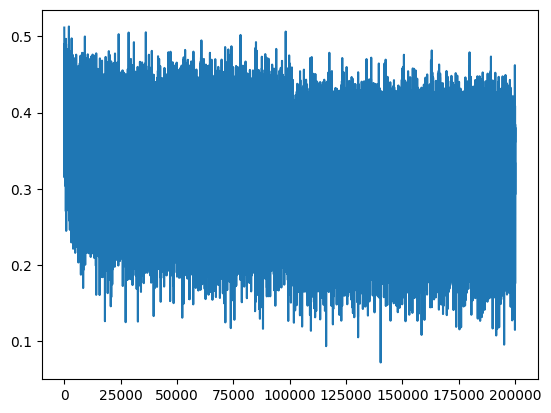

In [45]:
plt.plot(lossi)

After better initialization we don't have this hockey stick – easy part on the beginning. Thanks to this we can reach better score in the same number of iterations.

In [46]:
# loss on the whole dataset
@torch.no_grad()
def split_loss(split):
    X,Y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    emb = C[X]
    h = torch.tanh(emb.view(-1, embedding_dim*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss("train")
split_loss("dev")

train 2.0357086658477783
dev 2.1029491424560547


**original:**

train: 2.12</br>
dev: 2.17

**fix softmax confidently wrong (better init in second layer)**

train 2.0819787979125977</br>
dev 2.1412956714630127

**fix tanh too saturated (better init in first layer)**

train 2.0357086658477783</br>
dev 2.1029491424560547


The networ was shallowed so it learned even with many errors. It's not the case for deeper networks.


In [18]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join([itos[i] for i in out]))

mora.
mayah.
seel.
nah.
yam.
rensleighdrae.
caileed.
elin.
shy.
jen.
eden.
estanaraelyn.
malke.
cayshuberlyni.
jest.
jair.
jenipanthono.
ubelleda.
kylynn.
els.
